In [22]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s13/s1320903/Neuroglycerin/neukrill-net-work


In [26]:
model = pylearn2.utils.serial.load("/disk/scratch/neuroglycerin/models/superclasses_online.pkl")

Valid_y_y_1_nll
      I : Curve.Valid_y_y_1_nll   (y)
   Train_y_y_1_nll
      I : Curve.Train_y_y_1_nll   (y)
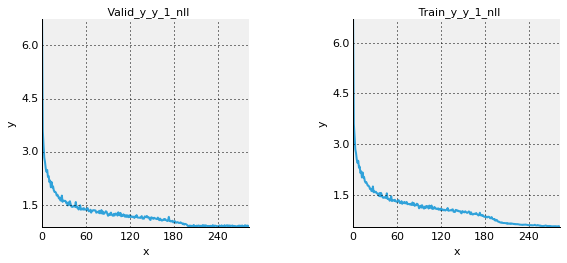

In [28]:
import neukrill_net.plotting as pl
pl.monitor_channels(model, ["valid_y_y_1_nll"], x_axis = "epoch") + pl.monitor_channels(model, ["train_y_y_1_nll"], x_axis = "epoch")

In [29]:
import neukrill_net.utils as utils
settings = neukrill_net.utils.Settings("settings.json")
validation_set = utils.train_test_split(settings.image_fnames, "validation", train_split=0.8)

In [30]:
validation_set

{u'acantharia_protist': [u'/disk/scratch/neuroglycerin/train/acantharia_protist/72486.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/72538.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/72640.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/72655.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/72726.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/72729.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/73207.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/73425.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/73440.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/73514.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/73949.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/74054.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/74148.jpg',
  u'/disk/scratch/neuroglycerin/train/acantharia_protist/74224.jpg',
  u'/disk/s

In [50]:
run_settings = neukrill_net.utils.load_run_settings("run_settings/superclasses_online.json", 
            settings, force=True)
verbose = False
augment = 1

yaml_string = neukrill_net.utils.format_yaml(run_settings, settings)
# load proxied objects
proxied = pylearn2.config.yaml_parse.load(yaml_string, instantiate=False)
# pull out proxied dataset
proxdata = proxied.keywords['dataset']
# force loading of dataset and switch to test dataset
proxdata.keywords['force'] = True
proxdata.keywords['training_set_mode'] = 'test'
proxdata.keywords['verbose'] = verbose
# then instantiate the dataset
dataset = pylearn2.config.yaml_parse._instantiate(proxdata)

In [42]:
if hasattr(dataset.X, 'shape'):
    N_examples = dataset.X.shape[0]
else:
    N_examples = len(dataset.X)
batch_size = 500
while N_examples%batch_size != 0:
    batch_size += 1
n_batches = int(N_examples/batch_size)
n_classes = len(settings.classes)

In [43]:
model.set_batch_size(batch_size)
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)

In [44]:
if type(X) == tuple:
    f = theano.function(X,Y)
else:
    f = theano.function([X],Y)

In [45]:
import neukrill_net.encoding as enc
hier = enc.get_hierarchy(settings)

In [46]:
hier

[['acantharia_protist',
  'acantharia_protist_big_center',
  'acantharia_protist_halo',
  'amphipods',
  'appendicularian_fritillaridae',
  'appendicularian_slight_curve',
  'appendicularian_s_shape',
  'appendicularian_straight',
  'artifacts',
  'artifacts_edge',
  'chaetognath_non_sagitta',
  'chaetognath_other',
  'chaetognath_sagitta',
  'chordate_type1',
  'copepod_calanoid',
  'copepod_calanoid_eggs',
  'copepod_calanoid_eucalanus',
  'copepod_calanoid_flatheads',
  'copepod_calanoid_frillyAntennae',
  'copepod_calanoid_large',
  'copepod_calanoid_large_side_antennatucked',
  'copepod_calanoid_octomoms',
  'copepod_calanoid_small_longantennae',
  'copepod_cyclopoid_copilia',
  'copepod_cyclopoid_oithona',
  'copepod_cyclopoid_oithona_eggs',
  'copepod_other',
  'crustacean_other',
  'ctenophore_cestid',
  'ctenophore_cydippid_no_tentacles',
  'ctenophore_cydippid_tentacles',
  'ctenophore_lobate',
  'decapods',
  'detritus_blob',
  'detritus_filamentous',
  'detritus_other',
  '

In [53]:
lengths = sum([len(array) for array in hier])
y = np.zeros((N_examples*augment,lengths))
# get the data specs from the cost function using the model
pcost = proxied.keywords['algorithm'].keywords['cost']
cost = pylearn2.config.yaml_parse._instantiate(pcost)
data_specs = cost.get_data_specs(model)

In [66]:
i = 0
for _ in range(augment):
    # make sequential iterator
    iterator = dataset.iterator(batch_size=batch_size,num_batches=n_batches,
                            mode='even_sequential', data_specs=data_specs)
    for batch in iterator:
        if type(X) == tuple:
            y[i*batch_size:(i+1)*batch_size,:] = f(batch[0],batch[1])[:,:]
        else:
            y[i*batch_size:(i+1)*batch_size,:] = f(batch[0])[:,:]
        i += 1

In [70]:
labels = dataset.y
labels.shape

(3089, 188)

In [157]:
import gzip
csv_in = gzip.open('/disk/scratch/neuroglycerin/submissions/alexnet_based_40aug.csv.gz', 'rb')
reader = csv.reader(csv_in, delimiter = ',')
a = reader.next()
len(a)    

122

In [149]:
a = reader.next()
float(a[1])

0.000384520817306111

In [151]:
type(settings.class_priors[0])

numpy.float64

In [198]:
settings.class_priors[0]

0.029305116033755275

In [196]:
csv_in = gzip.open('/disk/scratch/neuroglycerin/submissions/alexnet_based_40aug.csv.gz', 'rb')
reader = csv.reader(csv_in, delimiter = ',')
reader.next()
reader.next()

['1.jpg',
 '0.00026558903795148581',
 '5.7718559424990712e-08',
 '1.4683118331193512e-06',
 '2.2893271282020677e-06',
 '3.7239980095193914e-06',
 '0.00014681438233310473',
 '3.8181014332394625e-05',
 '0.00048945366143016145',
 '0.003795577656774185',
 '0.00023311754273436236',
 '9.4093292375418969e-06',
 '0.0042872252379311249',
 '1.9494633285432883e-06',
 '2.103941896258732e-07',
 '2.2891348438136561e-05',
 '4.9108900217476048e-06',
 '3.8531842061484411e-07',
 '2.6406609434204142e-05',
 '1.7587372180827288e-06',
 '9.9238868331297247e-08',
 '1.7620795694783808e-06',
 '1.0924166322576201e-07',
 '3.3720777807277891e-06',
 '7.8685394389044205e-07',
 '0.0026483890715098823',
 '7.3664155588737401e-06',
 '6.7832815056623197e-07',
 '6.1879789654994966e-05',
 '9.250931283233399e-07',
 '1.1582352566819054e-05',
 '1.54606114688427e-06',
 '7.4427748610050859e-08',
 '5.7363274419408583e-07',
 '0.0015934557013679296',
 '0.0097197928407695144',
 '0.029918990345322527',
 '0.079603294492699206',
 '0.2

In [202]:
csv_out = gzip.open('/disk/scratch/neuroglycerin/submissions/alexnet_based_40aug_prior_weighted.csv.gz', 'rb')
reader2 = csv.reader(csv_out, delimiter = ',')
reader2.next()
reader2.next()

['1.jpg',
 '0.0031695417375318651',
 '4.2905322230908653e-05',
 '0.00023536683929959647',
 '0.00016358465601875739',
 '5.609421424232273e-05',
 '0.0018858249272221573',
 '0.0023286667103675097',
 '0.0012382403627976938',
 '0.0047115103974258808',
 '0.00077019608381957596',
 '0.002695045400533197',
 '0.010233766427218183',
 '0.0022894654874598243',
 '0.00025401319443311054',
 '0.0022654598085310321',
 '0.00057469933688455174',
 '0.000316802482781085',
 '0.00061052755186631125',
 '0.00020925691412918584',
 '0.00094286357658487365',
 '0.00035100570283615922',
 '0.00016162257910027874',
 '0.00028982284468619931',
 '9.9600573612792555e-05',
 '0.0053470259027555188',
 '0.0039260654280114252',
 '7.9724419386142524e-05',
 '0.00071827092461354612',
 '0.00037332730955388763',
 '0.00014887348439874474',
 '0.00017610137064401018',
 '0.00012533069805391786',
 '0.00018181901208580843',
 '0.0026307082324969594',
 '0.010046600476523787',
 '0.029940013251718547',
 '0.07335380365102423',
 '0.18576456752

In [199]:
(0.00026558903795148581 * (1-0.1)) + (0.029305116033755275 * 0.1)

0.003169541737531865